# **Введение**

KNN является метрическим алгоритмом классического машинного обучения. Хотя от обучения здесь мало чего есть. Такие алгоритмы просто запоминают обучающую выборку и относительно неё определяют расстояния до новых объектов.

KNN может применяться как для классификации, так и для регрессии.

Вычислительнаю сложность метода KNN можно описать как O(N * M), где N - количество объектов в обучающей выборке, а M - количество признаков.

# **Математическое описание KNN**

## **Задача классификации**

Допустим у нас есть обучающая выборка 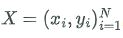, где . Также нам дана метрика расстояния . Нам нужно классифицировть объект *u*


Для этого найдём k самых близких к *u* объектов относительно данной метрики. 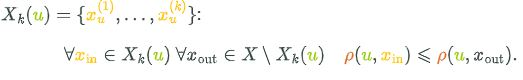

Класс нового объекта определим как наиболее часто встречающийся класс среди k соседей. 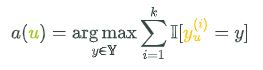

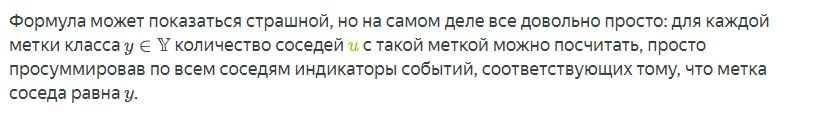

Тогда вероятность принадлежности объекта к классу: 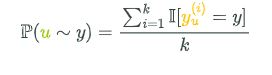

## **Задача регрессии**

Для регрессии у нас также есть обучающая выборка, метрика расстояния. Мы так же ищем k ближайших соседей. Однако теперь нам необходимо предсказать не класс объекта, а некое число, не категориальное значение, а численное - непрерывное. Здесь может помочь обучное усреднение. 

Мы усредняем y k ближайших соседей и считаем это ответом. 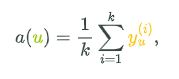

## **Взвешенный KNN**

Классические алгоритм очень прост, но он не использет всю предоставленную нам информацию, а именно, не использует расстояние от объекта до соседей. 

Эту проблему можно решить, задав функцию, которая даёт больший вес тем соседям, которые ближе к объекту.

Требования к такой функции следующие: 1) Положительная 2) Монотонно убывающая

Функции , удовлетворяющие этим свойствам называются ядерными функциям (kernel function)

Тогда итоговый класс высчитывается по формуле 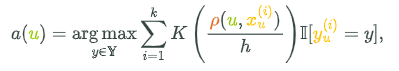. Где h - положительное число, называющееся шириной окна

Ширина окна, в свою очередь, сильно влияет как раз на качество модели. При слишком маленькой ширине модель сильно подстраивается под обучающую выборку и теряет свою обобщающую способность. При слишком большой ширине, напротив, модель становится слишком простой. Универсальной ширины окна не существует, поэтому для каждой задачи её приходится подбирать отдельно.

А для задачи регрессии используется формула 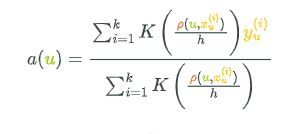

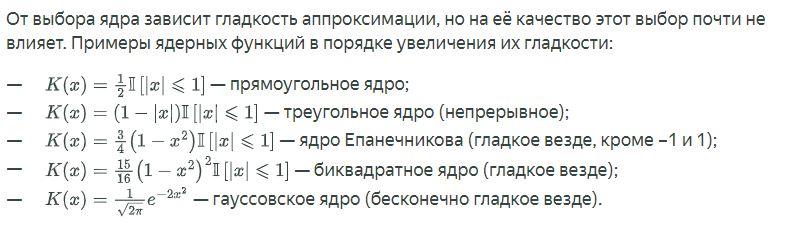

На практике чаще всего используют либо прямоугольное для простоты, либо гауссовское, в случае когда важна гладкость модели (это особенно важно в регрессии).

## **Выбор метрики**

Кроме евклидового расстояния между векторами, есдь множество других метрик.
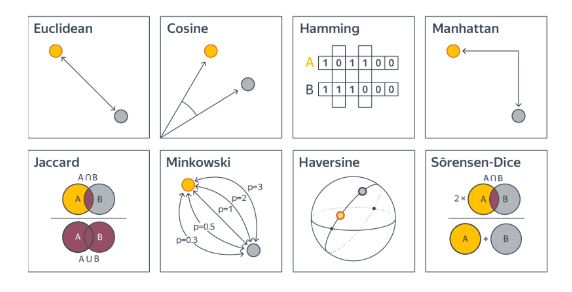 

 Евклидово расстояние 

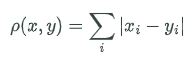 Манхэттенская метрика

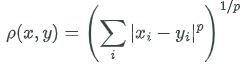 Метрика Минковского

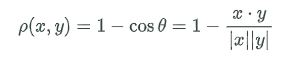 Косинусное расстояние

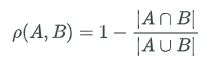 Расстояние Жаккара

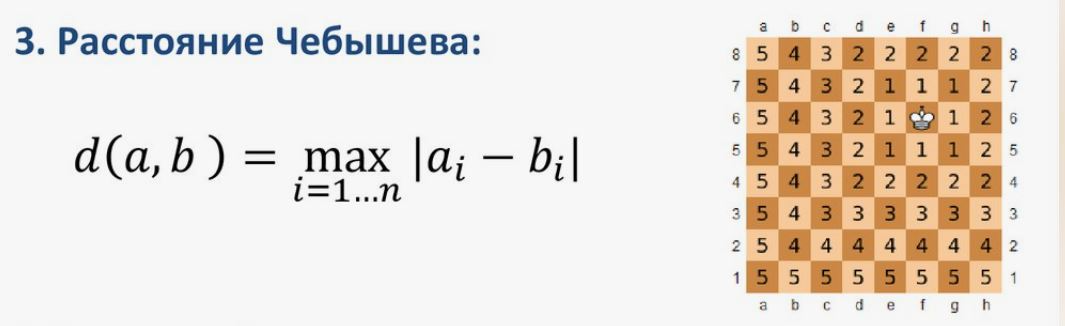

## **Переобучение**

Переобучение - очень странное понятие для KNN, у которого обучение отсутствует. Скорее, можно подобрать гиперпараметры (k, h, ядро и т.д) KNN так, что его результат будет зависеть от выбросов или соседей

## **Применение на практике**

Алгоритм неэффективен на очень больших объёмах данных из-за своей вычислительной сложности и занимаемой памяти. KNN не выявляет закономерностей о распределении данных. Чувствителен к масштабу и информативности данных.

И всё-таки, KNN до сих пор применяется в следующих задачах: 

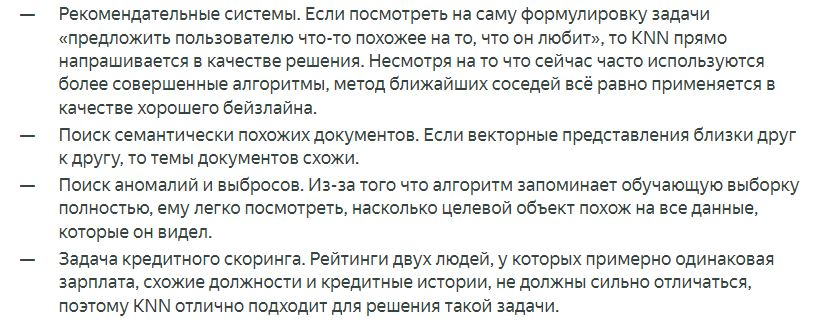


# **Реализация KNN классификатора, регрессора.**

In [9]:
import numpy as np

In [10]:
class KNN:
    """
    Параметры:
    1) k: int - количество соседей.
    2) metric: str, опционально - способ оценки расстояния между объектами. Поддерживаемые значения: 
       'euclidean' (по умолчанию), 'manhattan', 'minkowski', 'chebyshev', 'cosinus'.
    3) weight_func: callable, опционально - функция, принимающая на вход расстояния от объекта x из тестовой выборки 
       до всех объектов из train выборки и возвращающая веса каждого объекта. 
       Может также принимать ядерную функцию и окно h.
       Если используется метод Парзеновского окна с постояннgетр h типа float.
       Если h - функция, нужно передать callable.
       Пример:  def weight_func(dists, h, kernel):
                   return kernel(dists/h)
            model = KNN(weight_func=weight_func, h = 0.5, kernel='epanechnikov')
    4) h: float или callable, опционально - окно для метода Парзеновского окна. Игнорируется, если weight_func не использует h.
       Если h - функция, передать callable.
    5) kernel: str, callable, опционально - ядерная функция для метода Парзеновского окна. Поддерживаемые значения:
       'rectangular', 'triangular', 'epanechnikov', 'quartic', 'gaussian'.
       Если ядерная функция предоставляется через weight_func, этот параметр игнорируется.
    """
    def __init__(self, k = 3, metric = 'euclidean', weight_func = None, h = None, kernel = 'None'):
        self.k = k
        self.metric = metric
        self.weight_func = weight_func
        self.distance = {
            'euclidean': lambda x,y: np.sqrt(np.sum(np.square(x-y))),
            'manhattan': lambda x, y: np.sum(np.abs(x-y)),
            'minkowski': lambda x, y: np.power(np.sum(np.abs(x - y) ** (len(x))), 1/(len(x))),
            'chebyshev': lambda x, y: np.max(np.abs(x-y)),
            'cosinus': lambda x, y: 1 - (x*y)/(np.linalg.norm(x)*np.linalg.norm(y))
        }[metric]
        self.h = h
        self.kernel = {
            'rectangular': lambda r: 0.5*((np.abs(r) <= 1).astype(float)),
            'triangular': lambda r: (1 - np.abs(r))*(np.abs(r) <= 1).astype(float),
            'epanechnikov': lambda r: 0.75 * (1 - r**2) * ((np.abs(r) <= 1).astype(float)),
            'quartic': lambda r: ((15/16)*(1-r**2)**2)*(np.abs(r) <= 1).astype(float),
            'gaussian': lambda r: (1/np.sqrt(2 * np.pi)) * np.exp(-2 * r**2),
            'None': None
        }[kernel]

    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        predictions = []
        for x in X:

            dists = np.array([self.distance(x,y) for y in self.X])

            if self.weight_func:
                if self.h and self.kernel:
                    weights = self.weight_func(dists, self.h, self.kernel)
                    neighbors = np.argsort(dists)[:]
                else:
                    neighbors = np.argsort(dists)[:self.k+1]
                    k_dists = dists[neighbors]
                    weights = self.weight_func(k_dists)
                    
                predictions.append(np.argmax(np.bincount(self.y[neighbors], weights=weights[neighbors])))
                    
            else:
                neighbors = self.y[dists.argsort()[:self.k]]
                predictions.append(np.argmax(np.bincount(neighbors)))

        return np.array(predictions)
                
            

In [11]:
def parzen_window(dists, h, kernel):
    return kernel(dists/h)

def index_weighted(dists):
    weights = []
    k = len(dists)
    for i in range(k):
        weights.append((k+1-i)/k)
    return weights